In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split


import warnings
warnings.simplefilter('ignore')

In [2]:
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import cross_val_score
from scipy.stats import uniform

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

from sklearn.metrics import log_loss
from sklearn.calibration import CalibratedClassifierCV

from sklearn.feature_selection import RFECV

In [3]:
import xgboost
from xgboost import plot_importance
from xgboost import plot_tree
from xgboost import XGBClassifier

In [4]:
tourney_result = pd.read_csv('../input/kaggle_data/MNCAATourneyCompactResults.csv')

tourney_result = tourney_result.drop(['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'],axis=1)

In [5]:
coty = pd.read_csv('../input/coty.csv')
adj_eff = pd.read_csv('../input/self_calculated/adjusted_efficiencies.csv')
consistency = pd.read_csv('../input/self_calculated/consistency.csv')
maj_conf = pd.read_csv('../input/major_conferences.csv')

In [6]:
ordinals = pd.read_csv('../input/kaggle_data/MMasseyOrdinals.csv')

ordinals_df = ordinals.groupby(['SystemName','Season','TeamID']).last().reset_index()

POM_ordinals = ordinals_df[ordinals_df['SystemName']=='POM']
MOR_ordinals = ordinals_df[ordinals_df['SystemName']=='MOR']
DOK_ordinals = ordinals_df[ordinals_df['SystemName']=='DOK']
SAG_ordinals = ordinals_df[ordinals_df['SystemName']=='SAG']
LMC_ordinals = ordinals_df[ordinals_df['SystemName']=='LMC']

ordinals_df.SystemName.value_counts()

WOL    6177
RTH    6177
SAG    6177
MOR    6177
POM    6174
WLK    6174
DOL    6173
COL    6171
CNG    5847
SEL    5831
BIH    5830
WOB    5824
DUN    5521
RPI    5473
DOK    5194
WIL    5190
PIG    5187
MAS    4819
BOB    4778
STH    4524
REW    4524
PGH    4517
KRA    4507
DC     4472
SPW    4180
LMC    4179
DCI    4176
KPK    4170
RT     3836
SE     3771
       ... 
HRN     351
TOL     347
KEL     347
INP     347
UPS     345
HAT     345
AUS     345
PEQ     345
BP5     345
BNM     345
TS      344
RWP     344
DP      344
TBD     344
KCX     344
BNZ     344
BKM     341
RSE     341
CMV     330
WTE     327
BRZ     327
ERD     327
NOR     326
MGY     326
JON     326
PH      326
RM      326
GC      325
MIC     324
TRX     175
Name: SystemName, Length: 179, dtype: int64

In [7]:
all_teams = adj_eff.merge(coty,on=['Season','TeamID'])
all_teams = all_teams.merge(consistency,on=['Season','TeamID'])
all_teams = all_teams.merge(maj_conf,on=['Season','TeamID'])

all_teams = all_teams[['Season','TeamID','AdjNetEff','coty','tm_off_eff_std','tm_def_eff_std','MajorConf']]
all_teams.columns = ['Season','TeamID','AdjNetEff','coty','off_cons','def_cons','MajorConf']

all_teams

,Season,TeamID,AdjNetEff,coty,off_cons,def_cons,MajorConf
0,2003,1102,2.549120,0,23.752202,21.316022,0
1,2003,1103,-0.892082,0,14.223345,12.598310,0
2,2003,1104,16.005042,0,14.554749,15.141803,1
3,2003,1105,-17.739565,0,16.307845,19.190037,0
4,2003,1106,-9.118578,0,14.784855,18.732358,0
5,2003,1107,-18.899802,0,13.248183,16.426759,0
6,2003,1108,-11.597642,0,12.204852,13.567259,0
7,2003,1110,2.761780,0,14.825526,13.739147,0
8,2003,1111,-0.574032,0,14.179801,17.582319,0
9,2003,1112,27.877550,0,13.211491,13.021743,0


In [8]:
all_teams = all_teams.merge(POM_ordinals, on=['Season','TeamID'])
all_teams = all_teams.drop(['RankingDayNum','SystemName'],axis=1)
all_teams.rename(columns={'OrdinalRank':'Rank_POM'},inplace=True)
all_teams = all_teams.merge(MOR_ordinals, on=['Season','TeamID'])
all_teams = all_teams.drop(['RankingDayNum','SystemName'],axis=1)
all_teams.rename(columns={'OrdinalRank':'Rank_MOR'},inplace=True)
all_teams = all_teams.merge(SAG_ordinals, on=['Season','TeamID'])
all_teams = all_teams.drop(['RankingDayNum','SystemName'],axis=1)
all_teams.rename(columns={'OrdinalRank':'Rank_SAG'},inplace=True)
# all_teams = all_teams.merge(DOK_ordinals, on=['Season','TeamID'])
# all_teams = all_teams.drop(['RankingDayNum','SystemName'],axis=1)
# all_teams.rename(columns={'OrdinalRank':'Rank_DOK'},inplace=True)
# all_teams = all_teams.merge(LMC_ordinals, on=['Season','TeamID'])
# all_teams = all_teams.drop(['RankingDayNum','SystemName'],axis=1)
# all_teams.rename(columns={'OrdinalRank':'Rank_LMC'},inplace=True)
all_teams.columns

Index(['Season', 'TeamID', 'AdjNetEff', 'coty', 'off_cons', 'def_cons',
       'MajorConf', 'Rank_POM', 'Rank_MOR', 'Rank_SAG'],
      dtype='object')

In [9]:
df1 = tourney_result
df2 = all_teams

df = df1.merge(df2,left_on=['Season','WTeamID'],right_on=['Season','TeamID'], how="inner")

df = df.drop(['TeamID'],axis=1)

df = df.merge(df2,left_on=['Season','LTeamID'],right_on=['Season','TeamID'],how='inner')
df = df.drop(['TeamID'],axis=1)

print(df.columns)

Index(['Season', 'WTeamID', 'LTeamID', 'AdjNetEff_x', 'coty_x', 'off_cons_x',
       'def_cons_x', 'MajorConf_x', 'Rank_POM_x', 'Rank_MOR_x', 'Rank_SAG_x',
       'AdjNetEff_y', 'coty_y', 'off_cons_y', 'def_cons_y', 'MajorConf_y',
       'Rank_POM_y', 'Rank_MOR_y', 'Rank_SAG_y'],
      dtype='object')


In [10]:
df_win = df.copy()

df_lose = df_win.copy()

df_lose['AdjNetEff_x'] = df_win['AdjNetEff_y']
df_lose['AdjNetEff_y'] = df_win['AdjNetEff_x']

df_lose['coty_x'] = df_win['coty_y']
df_lose['coty_y'] = df_win['coty_x']

df_lose['off_cons_x'] = df_win['off_cons_y']
df_lose['off_cons_y'] = df_win['off_cons_x']

df_lose['def_cons_x'] = df_win['def_cons_y']
df_lose['def_cons_y'] = df_win['def_cons_x']

df_lose['Rank_POM_x'] = df_win['Rank_POM_y']
df_lose['Rank_POM_y'] = df_win['Rank_POM_x']

df_lose['Rank_MOR_x'] = df_win['Rank_MOR_y']
df_lose['Rank_MOR_y'] = df_win['Rank_MOR_x']

df_lose['Rank_SAG_x'] = df_win['Rank_SAG_y']
df_lose['Rank_SAG_y'] = df_win['Rank_SAG_x']

df_lose['MajorConf_x'] = df_win['MajorConf_y']
df_lose['MajorConf_y'] = df_win['MajorConf_x']

# df_lose['Rank_LMC_x'] = df_win['Rank_LMC_y']
# df_lose['Rank_LMC_y'] = df_win['Rank_LMC_x']

# df_lose['Rank_DOK_x'] = df_win['Rank_DOK_y']
# df_lose['Rank_DOK_y'] = df_win['Rank_DOK_x']

df_lose

,Season,WTeamID,LTeamID,AdjNetEff_x,coty_x,off_cons_x,def_cons_x,MajorConf_x,Rank_POM_x,Rank_MOR_x,Rank_SAG_x,AdjNetEff_y,coty_y,off_cons_y,def_cons_y,MajorConf_y,Rank_POM_y,Rank_MOR_y,Rank_SAG_y
0,2003,1421,1411,-8.798933,0,14.155399,18.094586,0,268,293,257,-15.290412,0,16.642408,14.289006,0,273,277,251
1,2003,1112,1436,2.581903,0,17.182535,13.232777,0,144,187,158,27.877550,0,13.211491,13.021743,0,3,4,2
2,2003,1112,1211,16.074004,0,13.140022,16.089789,0,41,54,39,27.877550,0,13.211491,13.021743,0,3,4,2
3,2003,1112,1323,21.393782,0,13.962640,19.286616,1,22,36,17,27.877550,0,13.211491,13.021743,0,3,4,2
4,2003,1113,1272,17.376061,0,9.061950,14.344667,0,20,23,24,18.390055,0,16.289954,17.096088,0,32,22,32
5,2003,1141,1166,21.599672,0,14.467639,15.065417,0,27,33,18,10.344505,0,16.061633,12.116463,0,50,50,48
6,2003,1143,1301,13.249313,0,15.369050,15.957973,1,48,31,46,13.464684,0,10.462607,15.701468,0,40,43,40
7,2003,1163,1140,19.820683,0,14.503437,15.874542,0,26,42,28,18.387632,1,15.141179,12.875165,1,23,17,23
8,2003,1163,1390,15.205756,0,11.922719,12.970978,0,30,25,29,18.387632,1,15.141179,12.875165,1,23,17,23
9,2003,1181,1161,5.709327,0,13.839161,15.873602,0,87,85,89,23.058384,0,11.334966,16.073131,1,8,10,10


In [11]:
df_win['result'] = 1
df_lose['result'] = 0

df_final = pd.concat((df_win,df_lose)).reset_index(drop=True)

df_final['AdjNetEff_Diff'] = df_final['AdjNetEff_x'] - df_final['AdjNetEff_y']
# df_final['Rank_POM_Diff'] = df_final['Rank_POM_x'] = df_final['Rank_POM_y']
# df_final['Rank_MOR_Diff'] = df_final['Rank_MOR_x'] = df_final['Rank_MOR_y']
# df_final['Rank_SAG_Diff'] = df_final['Rank_SAG_x'] = df_final['Rank_SAG_y']
# df_final['Rank_DOK_Diff'] = df_final['Rank_DOK_x'] = df_final['Rank_DOK_y']
# df_final['Rank_LMC_Diff'] = df_final['Rank_LMC_x'] = df_final['Rank_LMC_y']

df_final = df_final[df_final['Season']<2015]

df_final = df_final.drop(['Season','WTeamID','LTeamID','AdjNetEff_x','AdjNetEff_y'],axis=1)

#df_final = df_final.drop(['Season','WTeamID','LTeamID'],axis=1)

df_final

,coty_x,off_cons_x,def_cons_x,MajorConf_x,Rank_POM_x,Rank_MOR_x,Rank_SAG_x,coty_y,off_cons_y,def_cons_y,MajorConf_y,Rank_POM_y,Rank_MOR_y,Rank_SAG_y,result,AdjNetEff_Diff
0,0,16.642408,14.289006,0,273,277,251,0,14.155399,18.094586,0,268,293,257,1,-6.491479
1,0,13.211491,13.021743,0,3,4,2,0,17.182535,13.232777,0,144,187,158,1,25.295647
2,0,13.211491,13.021743,0,3,4,2,0,13.140022,16.089789,0,41,54,39,1,11.803546
3,0,13.211491,13.021743,0,3,4,2,0,13.962640,19.286616,1,22,36,17,1,6.483768
4,0,16.289954,17.096088,0,32,22,32,0,9.061950,14.344667,0,20,23,24,1,1.013994
5,0,16.061633,12.116463,0,50,50,48,0,14.467639,15.065417,0,27,33,18,1,-11.255168
6,0,10.462607,15.701468,0,40,43,40,0,15.369050,15.957973,1,48,31,46,1,0.215371
7,1,15.141179,12.875165,1,23,17,23,0,14.503437,15.874542,0,26,42,28,1,-1.433052
8,1,15.141179,12.875165,1,23,17,23,0,11.922719,12.970978,0,30,25,29,1,3.181876
9,0,11.334966,16.073131,1,8,10,10,0,13.839161,15.873602,0,87,85,89,1,17.349056


In [12]:
pt = PowerTransformer()
pt.fit(np.array(df_final['Rank_POM_x']).reshape(-1,1))
df_final['Rank_POM_x_v2'] = pt.transform(np.array(df_final['Rank_POM_x']).reshape(-1,1))
pt.fit(np.array(df_final['Rank_POM_y']).reshape(-1,1))
df_final['Rank_POM_y_v2'] = pt.transform(np.array(df_final['Rank_POM_y']).reshape(-1,1))

pt.fit(np.array(df_final['Rank_MOR_x']).reshape(-1,1))
df_final['Rank_MOR_x_v2'] = pt.transform(np.array(df_final['Rank_MOR_x']).reshape(-1,1))
pt.fit(np.array(df_final['Rank_MOR_y']).reshape(-1,1))
df_final['Rank_MOR_y_v2'] = pt.transform(np.array(df_final['Rank_MOR_y']).reshape(-1,1))

pt.fit(np.array(df_final['Rank_SAG_x']).reshape(-1,1))
df_final['Rank_SAG_x_v2'] = pt.transform(np.array(df_final['Rank_SAG_x']).reshape(-1,1))
pt.fit(np.array(df_final['Rank_SAG_y']).reshape(-1,1))
df_final['Rank_SAG_y_v2'] = pt.transform(np.array(df_final['Rank_SAG_y']).reshape(-1,1))

# pt.fit(np.array(df_final['Rank_LMC_x']).reshape(-1,1))
# df_final['Rank_LMC_x_v2'] = pt.transform(np.array(df_final['Rank_LMC_x']).reshape(-1,1))
# pt.fit(np.array(df_final['Rank_LMC_y']).reshape(-1,1))
# df_final['Rank_LMC_y_v2'] = pt.transform(np.array(df_final['Rank_LMC_y']).reshape(-1,1))

# pt.fit(np.array(df_final['Rank_DOK_x']).reshape(-1,1))
# df_final['Rank_DOK_x_v2'] = pt.transform(np.array(df_final['Rank_DOK_x']).reshape(-1,1))
# pt.fit(np.array(df_final['Rank_DOK_y']).reshape(-1,1))
# df_final['Rank_DOK_y_v2'] = pt.transform(np.array(df_final['Rank_DOK_y']).reshape(-1,1))

df_final = df_final.drop(['Rank_POM_x','Rank_POM_y'],axis=1)
df_final = df_final.drop(['Rank_MOR_x','Rank_MOR_y'],axis=1)
df_final = df_final.drop(['Rank_SAG_x','Rank_SAG_y'],axis=1)
# df_final = df_final.drop(['Rank_LMC_x','Rank_LMC_y'],axis=1)
# df_final = df_final.drop(['Rank_DOK_x','Rank_DOK_y'],axis=1)

df_final['Rank_POM_v2_Diff'] = df_final['Rank_POM_x_v2'] = df_final['Rank_POM_y_v2']
df_final['Rank_MOR_v2_Diff'] = df_final['Rank_MOR_x_v2'] = df_final['Rank_MOR_y_v2']
df_final['Rank_SAG_v2_Diff'] = df_final['Rank_SAG_x_v2'] = df_final['Rank_SAG_y_v2']
# df_final['Rank_LMC_v2_Diff'] = df_final['Rank_LMC_x_v2'] = df_final['Rank_LMC_y_v2']
# df_final['Rank_DOK_v2_Diff'] = df_final['Rank_DOK_x_v2'] = df_final['Rank_DOK_y_v2']

df_final = df_final.drop(['Rank_POM_x_v2','Rank_POM_y_v2'],axis=1)
df_final = df_final.drop(['Rank_MOR_x_v2','Rank_MOR_y_v2'],axis=1)
df_final = df_final.drop(['Rank_SAG_x_v2','Rank_SAG_y_v2'],axis=1)
# df_final = df_final.drop(['Rank_LMC_x_v2','Rank_LMC_y_v2'],axis=1)
# df_final = df_final.drop(['Rank_DOK_x_v2','Rank_DOK_y_v2'],axis=1)

In [13]:
# df_final[['AdjNetEff_Diff','Rank_POM_v2_Diff','Rank_MOR_v2_Diff','Rank_SAG_v2_Diff']].corr()

In [14]:
# df_final.Rank_POM_v2_Diff.hist()

In [15]:
# print(df_final.columns)
# df_final = df_final[['Rank_POM_v2_Diff',
#        'Rank_MOR_v2_Diff', 'Rank_SAG_v2_Diff','result']]

In [16]:
X = df_final.drop('result',axis=1)
y = df_final.result
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=1)

In [17]:
def best_model(model):
    print(model.best_score_)
    print(model.best_params_)
    print(model.best_estimator_)
def get_auc_scores(y_actual, method, method2):
    auc_score = roc_auc_score(y_actual, method)
    fpr_df, tpr_df, _ = roc_curve(y_actual, method2)
    return (auc_score, fpr_df, tpr_df)

In [18]:
param_grid = {'C':np.logspace(start=-5,stop=3,num=9),
            'solver':['lbfgs','liblinear','sag','saga'],
            'max_iter':[50,100]
}
LogReg_Grid = GridSearchCV(LogisticRegression(),param_grid, cv=10, refit=True, verbose=0, scoring='neg_log_loss')
LogReg_Grid.fit(X_train, y_train)
best_model(LogReg_Grid)

-0.5411467216885488
{'C': 0.001, 'max_iter': 50, 'solver': 'liblinear'}
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=50,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [19]:
param_grid ={'alpha':np.logspace(start=-5,stop=3,num=9),
             'max_iter':[100,500,1000],
             'loss':['log','modified_huber']
}
SGD_Grid = GridSearchCV(SGDClassifier(),param_grid, cv=10,refit=True, verbose=0, scoring='neg_log_loss')
SGD_Grid.fit(X_train,y_train)
best_model(SGD_Grid)

-0.541454888589774
{'alpha': 1.0, 'loss': 'log', 'max_iter': 100}
SGDClassifier(alpha=1.0, average=False, class_weight=None, early_stopping=False,
              epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
              learning_rate='optimal', loss='log', max_iter=100,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


In [20]:
LR_model = LogReg_Grid.best_estimator_
SGD_model = SGD_Grid.best_estimator_

auc_LR, fpr_LR, tpr_LR = get_auc_scores(y_test, LR_model.predict(X_test),LR_model.predict_proba(X_test)[:,1])
auc_SGD, fpr_SGD, tpr_SGD = get_auc_scores(y_test, SGD_model.predict(X_test),SGD_model.predict_proba(X_test)[:,1])

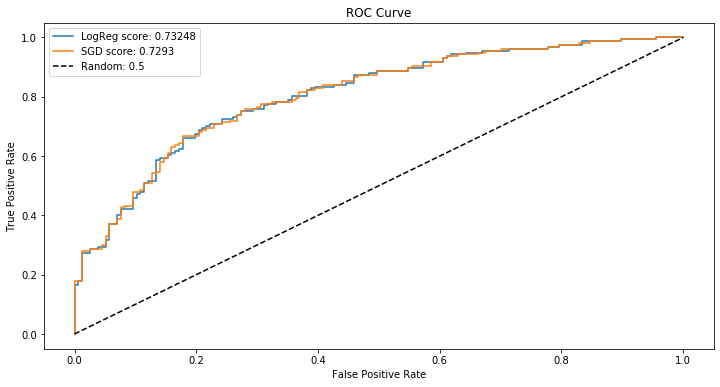

In [21]:
fig = plt.figure(figsize=(12,6), linewidth=1)
plt.plot(fpr_LR, tpr_LR, label='LogReg score: ' + str(round(auc_LR,5)))
plt.plot(fpr_SGD, tpr_SGD, label='SGD score: ' + str(round(auc_SGD,5)))
plt.plot([0,1],[0,1],'k--', label='Random: 0.5')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')

plt.show()

In [22]:
from sklearn.calibration import calibration_curve

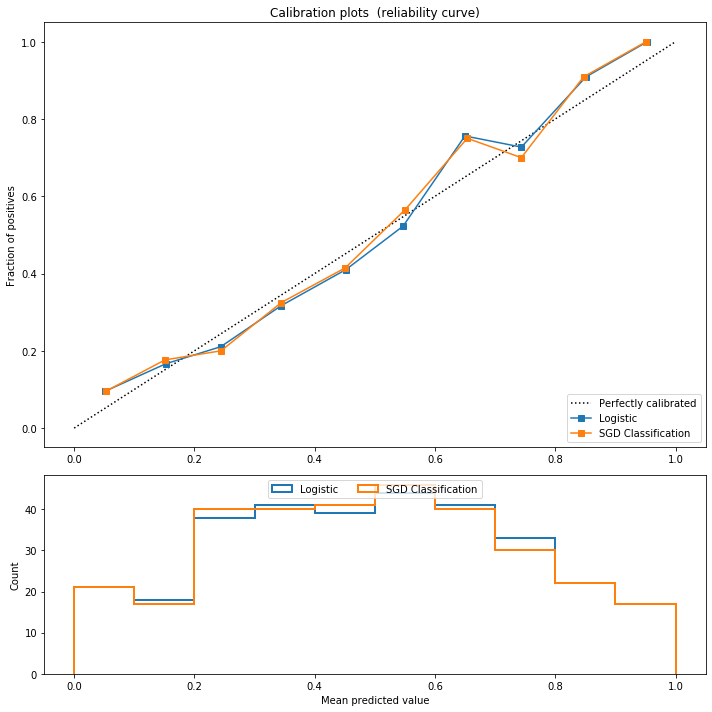

In [23]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(LR_model, 'Logistic'),
                  (SGD_model, 'SGD Classification')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

Otpimal number of features: 1


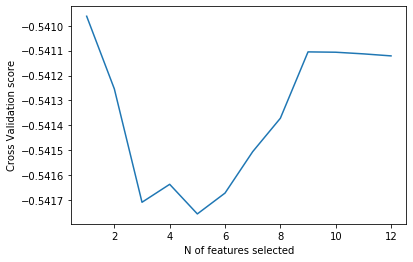

In [24]:
min_features_to_select = 1 
lr_clf = LR_model
rfecv = RFECV(estimator=lr_clf, step=1, cv=10, scoring='neg_log_loss', min_features_to_select=min_features_to_select)
rfecv.fit(X_train,y_train)

print('Otpimal number of features: %d' % rfecv.n_features_)

plt.figure()
plt.xlabel('N of features selected')
plt.ylabel('Cross Validation score')
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

In [25]:
for i in range(X_train.shape[1]):
    print('Column %s, Selected %s, Rank %.3f' % (X_train.columns[i], rfecv.support_[i], rfecv.ranking_[i]))

Column coty_x, Selected False, Rank 10.000
Column off_cons_x, Selected False, Rank 2.000
Column def_cons_x, Selected False, Rank 4.000
Column MajorConf_x, Selected False, Rank 11.000
Column coty_y, Selected False, Rank 7.000
Column off_cons_y, Selected False, Rank 5.000
Column def_cons_y, Selected False, Rank 3.000
Column MajorConf_y, Selected False, Rank 8.000
Column AdjNetEff_Diff, Selected True, Rank 1.000
Column Rank_POM_v2_Diff, Selected False, Rank 12.000
Column Rank_MOR_v2_Diff, Selected False, Rank 6.000
Column Rank_SAG_v2_Diff, Selected False, Rank 9.000


In [26]:
test_df = pd.read_csv('../input/kaggle_data/MSampleSubmissionStage1.csv')

In [27]:
test_df['Season'] = test_df['ID'].map(lambda x: int(x[:4]))
test_df['WTeamID'] = test_df['ID'].map(lambda x: int(x[5:9]))
test_df['LTeamID'] = test_df['ID'].map(lambda x: int(x[10:14]))
test_df

,ID,Pred,Season,WTeamID,LTeamID
0,2015_1107_1112,0.5,2015,1107,1112
1,2015_1107_1116,0.5,2015,1107,1116
2,2015_1107_1124,0.5,2015,1107,1124
3,2015_1107_1125,0.5,2015,1107,1125
4,2015_1107_1129,0.5,2015,1107,1129
5,2015_1107_1138,0.5,2015,1107,1138
6,2015_1107_1139,0.5,2015,1107,1139
7,2015_1107_1140,0.5,2015,1107,1140
8,2015_1107_1153,0.5,2015,1107,1153
9,2015_1107_1157,0.5,2015,1107,1157


In [28]:
print(all_teams.columns)


Index(['Season', 'TeamID', 'AdjNetEff', 'coty', 'off_cons', 'def_cons',
       'MajorConf', 'Rank_POM', 'Rank_MOR', 'Rank_SAG'],
      dtype='object')


In [29]:
df = test_df.merge(all_teams, left_on=['Season','WTeamID'], right_on=['Season','TeamID'],how='left')
df.rename(columns={'AdjNet_Eff':'AdjNetEff_x','coyt':'coty_x','off_cons':'off_cons_x','def_cons':'def_cons_x'},inplace=True)
df = df.drop('TeamID',axis=1)
df = df.merge(all_teams, left_on=['Season','LTeamID'],right_on=['Season','TeamID'],how='left')
df.rename(columns={'AdjNet_Eff':'AdjNetEff_y','coyt':'coty_y','off_cons':'off_cons_y','def_cons':'def_cons_y'},inplace=True)
df['AdjNetEff_Diff'] = df['AdjNetEff_x'] - df['AdjNetEff_y']
# df['Rank_POM_Diff'] = df['Rank_POM_x'] = df['Rank_POM_y']
# df['Rank_MOR_Diff'] = df['Rank_MOR_x'] = df['Rank_MOR_y']
# df['Rank_SAG_Diff'] = df['Rank_SAG_x'] = df['Rank_SAG_y']
df = df.drop(['TeamID','AdjNetEff_x','AdjNetEff_y','ID','Pred','Season','WTeamID','LTeamID'],axis=1)


df = df.drop_duplicates()

df

,coty_x,off_cons_x,def_cons_x,MajorConf_x,Rank_POM_x,Rank_MOR_x,Rank_SAG_x,coty_y,off_cons_y,def_cons_y,MajorConf_y,Rank_POM_y,Rank_MOR_y,Rank_SAG_y,AdjNetEff_Diff
0,0,16.213193,14.331449,0,132,145,130,0,12.686059,12.650090,0,2,1,4,-30.931605
1,0,16.213193,14.331449,0,132,145,130,0,12.225885,20.058701,1,29,24,25,-14.828868
2,0,16.213193,14.331449,0,132,145,130,0,15.242386,15.808386,1,15,18,14,-22.772427
3,0,16.213193,14.331449,0,132,145,130,0,16.700681,15.470556,0,149,131,150,1.271728
4,0,16.213193,14.331449,0,132,145,130,0,15.796849,20.349861,0,39,48,45,-13.015081
5,0,16.213193,14.331449,0,132,145,130,0,13.316342,13.537010,0,54,71,59,-10.272515
6,0,16.213193,14.331449,0,132,145,130,0,16.713787,15.209442,1,23,25,20,-19.078222
7,0,16.213193,14.331449,0,132,145,130,0,12.803799,12.598343,0,31,28,36,-16.316384
8,0,16.213193,14.331449,0,132,145,130,0,17.266104,14.345523,0,34,51,50,-12.161799
9,0,16.213193,14.331449,0,132,145,130,1,14.068286,16.489205,0,148,164,145,1.251034


In [30]:
pt = PowerTransformer()
pt.fit(np.array(df['Rank_POM_x']).reshape(-1,1))
df['Rank_POM_x_v2'] = pt.transform(np.array(df['Rank_POM_x']).reshape(-1,1))
pt.fit(np.array(df['Rank_POM_y']).reshape(-1,1))
df['Rank_POM_y_v2'] = pt.transform(np.array(df['Rank_POM_y']).reshape(-1,1))

pt.fit(np.array(df['Rank_MOR_x']).reshape(-1,1))
df['Rank_MOR_x_v2'] = pt.transform(np.array(df['Rank_MOR_x']).reshape(-1,1))
pt.fit(np.array(df['Rank_MOR_y']).reshape(-1,1))
df['Rank_MOR_y_v2'] = pt.transform(np.array(df['Rank_MOR_y']).reshape(-1,1))

pt.fit(np.array(df['Rank_SAG_x']).reshape(-1,1))
df['Rank_SAG_x_v2'] = pt.transform(np.array(df['Rank_SAG_x']).reshape(-1,1))
pt.fit(np.array(df['Rank_SAG_y']).reshape(-1,1))
df['Rank_SAG_y_v2'] = pt.transform(np.array(df['Rank_SAG_y']).reshape(-1,1))

df = df.drop(['Rank_POM_x','Rank_POM_y'],axis=1)
df = df.drop(['Rank_MOR_x','Rank_MOR_y'],axis=1)
df = df.drop(['Rank_SAG_x','Rank_SAG_y'],axis=1)

df['Rank_POM_v2_Diff'] = df['Rank_POM_x_v2'] = df['Rank_POM_y_v2']
df['Rank_MOR_v2_Diff'] = df['Rank_MOR_x_v2'] = df['Rank_MOR_y_v2']
df['Rank_SAG_v2_Diff'] = df['Rank_SAG_x_v2'] = df['Rank_SAG_y_v2']

df = df.drop(['Rank_POM_x_v2','Rank_POM_y_v2'],axis=1)
df = df.drop(['Rank_MOR_x_v2','Rank_MOR_y_v2'],axis=1)
df = df.drop(['Rank_SAG_x_v2','Rank_SAG_y_v2'],axis=1)

In [31]:
test_pred = lr_clf.predict_proba(df)[:,1]
len(test_pred)

11390

In [32]:
submission_df = pd.read_csv('../input/kaggle_data/MSampleSubmissionStage1.csv')
submission_df['Pred'] = test_pred
submission_df
len(submission_df)

11390

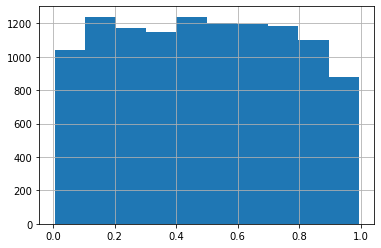

In [33]:
submission_df['Pred'].hist()

In [35]:
submission_df.to_csv('../submissions/Square6.csv', index=False)